# Image classification for Muffins and Chihuahuas

In this project, we will test different architectures and machine learning methods for image classification. Specifically, we will use Torch to train a neural network for the binary classification of muffins and Chihuahuas based on images from a Kaggle dataset.

*Note; using Torch is optional as the recommended library was Keras. Using Torch is a personal preference due to some of it's low-level capabilities.*

This project is supposed to be run in Google Colab (or another cloud provider if applicable) due to GPU-access. This speeds up the training process significantly compared to running it on the local CPU.

## Setup
One of the main advantages with google colab it it's ability to run machine learning models independent of the environment of our local operating system. As CUDA (for NVIDIA drivers and GPUs) are not available for unix, I highly recommend running it on either a Linux-based system or in the cloud. This will enable us to connect to a free GPU-runtime.

In [ ]:
# Checking if kaggle is installed, otherwise install it in our environment
!pip show kaggle || pip install kaggle

Name: kaggle
Version: 1.6.14
Summary: Kaggle API
Home-page: https://github.com/Kaggle/kaggle-api
Author: Kaggle
Author-email: support@kaggle.com
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: bleach, certifi, python-dateutil, python-slugify, requests, six, tqdm, urllib3
Required-by: 


In [ ]:
# Importing dependencies for PyTorch and loading

%matplotlib inline

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import shutil
from sklearn.model_selection import KFold

# Setup
import zipfile
from pathlib import Path

# PyTorch dependencies
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.transforms import Resize, ToTensor, Normalize, Compose, Grayscale, Lambda, RandomHorizontalFlip, RandomRotation
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader


# Check PyTorch version
print("PyTorch version:", torch.__version__)

# Set NumPy print options
np.set_printoptions(precision=3, threshold=11)

# Matplotlib config
plt.ioff()
plt.rc('image', cmap='gray_r')
plt.rc('grid', linewidth=1)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0') #, figsize=(16,9)

PyTorch version: 2.3.0+cu121


**From the Kaggle API docs:**

*In order to use the Kaggle’s public API, you must first authenticate using an API token. Go to the 'Account' tab of your user profile and select 'Create New Token'. This will trigger the download of kaggle.json, a file containing your API credentials.*

*If you are using the Kaggle CLI tool, the tool will look for this token at `~/.kaggle/kaggle.json` on Linux, OSX, and other UNIX-based operating systems, and at `C:\Users\<Windows-username>\.kaggle\kaggle.json` on Windows. If the token is not there, an error will be raised. Hence, once you’ve downloaded the token, you should move it from your Downloads folder to this folder.*

*If you are using the Kaggle API directly, where you keep the token doesn’t matter, so long as you are able to provide your credentials at runtime.*

Link: https://www.kaggle.com/docs/api

In [ ]:
# Husk å bytte tilbake til 'xxxxxx'

# Importing project file directly from Kaggle API
os.environ['KAGGLE_USERNAME'] = "svendsenorway"
os.environ['KAGGLE_KEY'] = "84f419311429a45a1fda6f07f65ffe79"

# os.environ['KAGGLE_USERNAME'] = "<your username>"
# os.environ['KAGGLE_KEY'] = "<your token>"
!kaggle datasets download -d samuelcortinhas/muffin-vs-chihuahua-image-classification

Dataset URL: https://www.kaggle.com/datasets/samuelcortinhas/muffin-vs-chihuahua-image-classification
License(s): CC0-1.0
100% 473M/474M [00:04<00:00, 183MB/s]
100% 474M/474M [00:04<00:00, 123MB/s]


Enabling connection to GPU for efficient computation:

In [ ]:
!nvidia-smi

Tue May 28 10:50:57 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    print("CUDA (GPU support) is available and enabled!")
    print("CUDA device name:", torch.cuda.get_device_name(0))
else:
    print("CUDA (GPU support) is not available. Using CPU.")

# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)


CUDA (GPU support) is available and enabled!
CUDA device name: Tesla T4


Quick check to verify that we are using a high-RAM runtime environment:

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


## Initial Data Exploration

## Preprocessing

Before doing our initial model selection, we need to ensure that our data is optimized for our model. Among other things, this includes transforming the images from JPG to RGB (or grayscale) pixel values and scale them down.

In [ ]:
# Unzipping the dataset
zip_path = 'muffin-vs-chihuahua-image-classification.zip'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("./data")

# Checking the extracted files
extracted_dir = Path("./data")
print("Contents of Extracted Directory:", os.listdir(extracted_dir))

# Assuming the structure contains 'train' and 'test', we check their contents too
train_data_dir = extracted_dir / 'train'
test_data_dir = extracted_dir / 'test'
print("Training Subdirectories:", os.listdir(train_data_dir))
print("Testing Subdirectories:", os.listdir(test_data_dir))


Contents of Extracted Directory: ['train', 'test']
Training Subdirectories: ['muffin', 'chihuahua']
Testing Subdirectories: ['muffin', 'chihuahua']


In [ ]:
from pathlib import Path

# Define the paths for training and testing data
train_data_dir = Path("./data/train").resolve()  # Converts to absolute path
test_data_dir = Path("./data/test").resolve()    # Converts to absolute path

# List all image files in the training and testing directories using absolute paths
train_image_files = list(train_data_dir.glob('*/*.jpg'))
test_image_files = list(test_data_dir.glob('*/*.jpg'))

# Displaying the total number of images in each set and some file paths
print(f"Total number of training images: {len(train_image_files)}")
print(f"Total number of testing images: {len(test_image_files)}")
print(f"The testing data is {len(test_image_files)/len(train_image_files) * 100:.2f}% the size of the training data")

Total number of training images: 4733
Total number of testing images: 1184
The testing data is 25.02% the size of the training data


For simplicity we will define our own dataset class, which will inherit from `Torch.Dataset`. This modification let's us separate the images easily when using the data in the model and also creates a modular component which is easy to use.

In [ ]:
class MuffinChihuahuaDataset(Dataset):
    """Custom dataset class for Muffin vs Chihuahua image classification.

    This class handles loading and transforming images for the task of
    classifying images as either pictures of muffins or Chihuahuas. It
    supports loading images in grayscale format and applying a series
    of transformations to prepare them for model training.

    Attributes:
        file_paths (list): A list of paths to the image files.
        transform (callable, optional): A function/transform that takes in
            a PIL image and returns a transformed version. Typically used
            to apply preprocessing steps such as resizing, normalization, and
            converting to tensor.
    """

    def __init__(self, file_paths, transform=None):
        """
        Initializes the dataset with file paths and an optional transform.

        Args:
            file_paths (list): A list of file paths to the images.
            transform (callable, optional): Transform to be applied on an image.
        """
        self.file_paths = file_paths
        self.transform = transform

    def __len__(self):
        """
        Returns:
            int: The number of items in the dataset.
        """
        return len(self.file_paths)

    def __getitem__(self, idx):
        """
        Fetches the image and label at the given index, applying any specified
        transformations.

        Args:
            idx (int): The index of the item to retrieve.

        Returns:
            tuple: A tuple containing the transformed image and its label, where
            the label is 1 for 'chihuahua' and 0 for 'muffin'.
        """
        image_path = self.file_paths[idx]
        # Load the image with PIL and convert to grayscale
        image = Image.open(image_path).convert('L')

        # Apply transformations or convert to tensor if no transformations are provided
        if self.transform:
            image = self.transform(image)
        else:
            # Directly convert PIL image to tensor and normalize if no other transform is specified
            image = ToTensor()(image)

        label = 1 if 'chihuahua' in image_path.parent.name else 0

        return image, label


In [ ]:
def show_images(images, labels):
    """Displays a grid of images and their labels.

    Args:
        images (tensor): Batch of images.
        labels (list): Corresponding labels for the images.
    """
    plt.figure(figsize=(8, 8))
    for i, image in enumerate(images):
        plt.subplot(2, 2, i + 1)
        plt.imshow(image.permute(1, 2, 0))  # Adjust the channel order for plotting
        plt.title("Chihuahua" if labels[i] == 1 else "Muffin")
        plt.axis("off")
    plt.show()

Now, we want to split our data to ensure that we don't make our model dependent on our test data. As the imported dataset already has a split between the training and test information, we only need to split our training data:

In [ ]:
from sklearn.model_selection import train_test_split

# Splitting the training data into training and validation sets
train_image_files, val_image_files = train_test_split(train_image_files, test_size=0.2, random_state=42)

# Display the number of images in each set
print(f"Number of training images: {len(train_image_files)}")
print(f"Number of validation images: {len(val_image_files)}")

Number of training images: 3786
Number of validation images: 947


As we now have our dataset splitted nicely, we can now apply the given transformations and preprocessing that is needed for the model to accurately make predictions.
*Note that a PyTorch tensor is very similar to an n-size numpy array.*

In [ ]:
# For training data (with data augmentation)
train_transform = Compose([
    Resize((256, 256), antialias=True),  # Resize the image
    RandomHorizontalFlip(),  # Randomly flip the images horizontally
    RandomRotation(10),  # Randomly rotate the image by +/- 10 degrees
    ToTensor(),  # Convert PIL Image to tensor
    Normalize(mean=[0.5], std=[0.5])  # Normalize the tensor for grayscale
])

# For validation and test data (without data augmentation)
val_test_transform = Compose([
    Resize((256, 256), antialias=True),  # Resize the image
    ToTensor(),  # Convert PIL Image to tensor
    Normalize(mean=[0.5], std=[0.5])  # Normalize the tensor for grayscale
])

# datasets with different transformations
train_dataset = MuffinChihuahuaDataset(train_image_files, transform=train_transform)
val_dataset = MuffinChihuahuaDataset(val_image_files, transform=val_test_transform)
test_dataset = MuffinChihuahuaDataset(test_image_files, transform=val_test_transform)

Now we have also transformed the images for model use. This includes:

- **Resizing** each image to $256$x$256$ pixels, ensuring that all images have a uniform size for processing by the neural network.
- **Converting the images to a PyTorch tensor** of type float. This step is crucial as it transforms our images into a format suitable for matrix calculations, which are fundamental to the operations within neural networks.
- **Normalizing** each image to ensure that the pixel values are scaled appropriately, which can help speed up training and lead to faster convergence. For grayscale images, this process involves adjusting the pixel values to have a mean of 0 and a standard deviation of $1$. The normalization step is crucial for model performance and is achieved by:

1. **Scaling the Pixel Values:** Initially, the `ToTensor()` transformation converts the pixel values to a range of $[0,1]$ by dividing each pixel by 255, the maximum value for an 8-bit grayscale image.

2. **Standardizing the Image:** The image is then standardized by subtracting the mean value ($0.5$) from every pixel, and dividing by the standard deviation ($0.5$). This step transforms the pixel values to have a new range, with a mean of $0$ and standard deviation of $1$, effectively normalizing the data for the single grayscale channel.

We adopt a **different approach for the training data** compared to validation and test data:

*   **Data Augmentation** is applied exclusively to the training data. Techniques such as random horizontal flipping and random rotations help the model generalize better by introducing variability in the training data, simulating different perspectives and conditions. This reduces overfitting, especially crucial when the amount of available data is limited.

*   For **validation and test data**, data augmentation is excluded to evaluate the model's performance on unaltered images. This ensures that the validation and testing phases provide an accurate assessment of the model's ability to generalize to new, unseen data.



In machine learning, particularly when working with large datasets, it's impractical to load the entire dataset into memory at once. This is where `DataLoaders` come into play.

In this project, `DataLoaders` are used to efficiently manage the data in batches during the model training, validation, and testing phases. The `train_loader` shuffles the training data to ensure that each batch is different, which helps in better generalization of the model.

For validation (`val_loader`) and testing (`test_loader`), shuffling is not necessary as the model is not being trained on these datasets, but rather being evaluated. The batch size for all loaders is set to 4, balancing the load on memory and computational efficiency.

In [ ]:
# Reproducibility
torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

In [ ]:
from torch.utils.data import Sampler
import random
# The custom sampler was needed to run on GPU
class CustomBatchSampler(Sampler):
    def __init__(self, dataset, batch_size):
        self.dataset_indices = list(range(len(dataset)))
        self.batch_size = batch_size

    def __iter__(self):
        random.shuffle(self.dataset_indices)  # Shuffle at the start of each epoch
        for idx in self.dataset_indices:
            yield idx

    def __len__(self):
        return len(self.dataset_indices)



basic_transform = Compose([
    Resize((256, 256),antialias=True),  # Resize all images to the same size
    ToTensor(),
])

# Usage
test_dataset = MuffinChihuahuaDataset(train_image_files, transform=basic_transform)
custom_sampler = CustomBatchSampler(test_dataset, batch_size=4)
test_loader = DataLoader(test_dataset, sampler=custom_sampler, generator=torch.Generator(device='cuda'))


for images, labels in test_loader:
    print("Batch loaded successfully.")
    break


Batch loaded successfully.


In [ ]:
# Quick test
basic_train_dataset = MuffinChihuahuaDataset(train_image_files, transform=basic_transform)
basic_train_loader = DataLoader(basic_train_dataset, batch_size=4, shuffle=False, sampler=custom_sampler, generator=torch.Generator(device='cuda'))

for images, labels in basic_train_loader:
    try:
        images = images.to(device)
        print("Batch successfully moved to GPU.")
        break
    except RuntimeError as e:
        print("Error when moving batch to GPU:", e)
        break

Batch successfully moved to GPU.


In [ ]:
# Custom shuffling to avoid GPU tensor errors
custom_sampler = CustomBatchSampler(train_dataset, batch_size=4)

# Data loaders for training, validation, and testing
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=False, sampler=custom_sampler)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False,)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

We can also look at some of the images in our training data for visualization purposes:

*Note; Random number generators (RNGs) behave differently on CPUs and GPUs. On a GPU, PyTorch uses a different RNG for each kernel. If there's an issue with the initialization or synchronization of these RNGs on the GPU, it could potentially lead to a kind of device-related error. The solution to this is to use the validation loader where the `shuffle=False`. Another class was created, `CustomBatchSampler`, which shuffles manually to avoid issues with CUDA.*

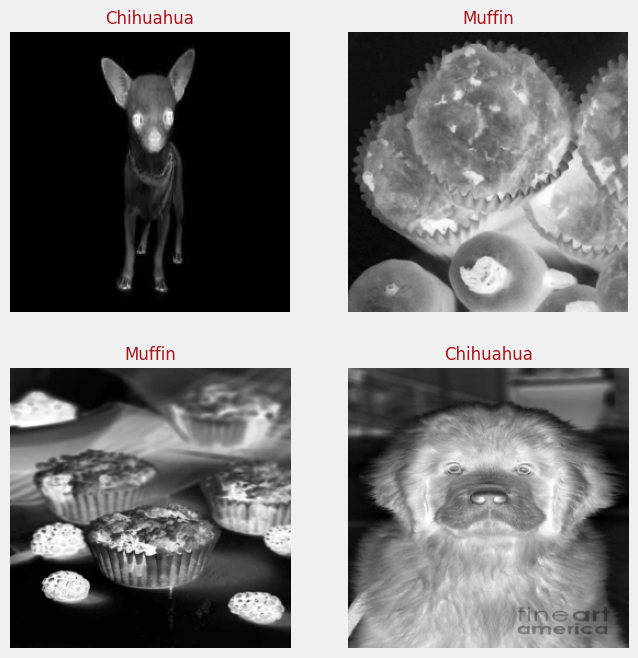

In [ ]:
for images, labels in val_loader:
    images, labels = images.to(device), labels.to(device)
    show_images(images.cpu(), labels.cpu())  # Move the images and labels back to CPU for visualization
    break

To compare this, we can look at how the images look without any of the transformations (other than the resizing for Torch DataLoader):

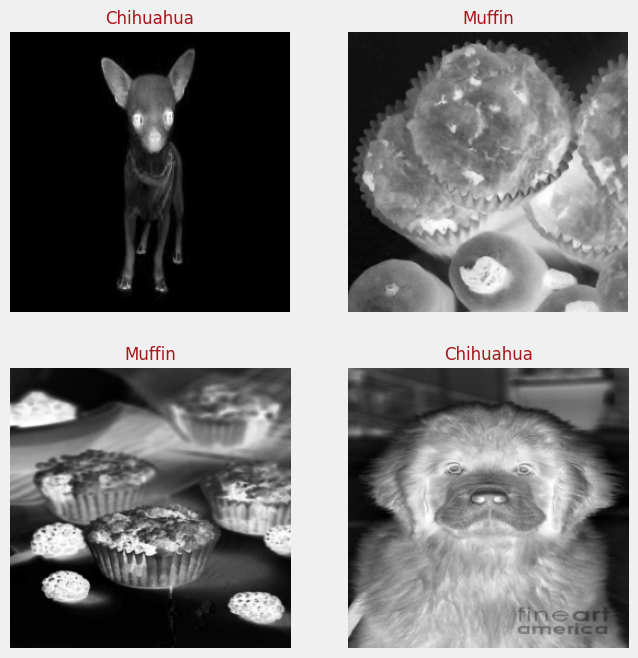

In [ ]:
# Create a simple resize transform
resize_transform = transforms.Compose([
    Resize((256, 256), antialias=True),  # Resize the image to a fixed size
    ToTensor(),
])

# Dataset with only resizing applied
pre_processed_dataset = MuffinChihuahuaDataset(val_image_files, transform=resize_transform)
pre_processed_train_loader = DataLoader(pre_processed_dataset, batch_size=4, shuffle=False)

# Visualize some training images
for images, labels in pre_processed_train_loader:
    show_images(images, labels)
    break


## Model Selection

As we are working with binary classification of images, we can now experiment with different deep architectures to obtain a good result. In particular, we will be focusing on Convolutional Neural Networks (as these are very efficient for computer vision tasks) and utilize Torch's powerful gradient tools. For simplicity, we will start with a simple CNN:

Note that when creating custom models in PyTorch, we create classes from the `nn` module. This is a modular approach and one of the perks of PyTorch.

In some cases, we will want to specify models that are more complex than a sequence of existing Modules; for these cases we can define our own Modules by subclassing `nn.Module` and defining a forward which receives input Tensors and produces output Tensors using other modules or other autograd operations on Tensors.

**Design Choices:**

* **Convolutional Layers:** We start with a modest number of filters to capture low-level features, increasing in deeper layers to identify more complex patterns.
*   **Pooling Layers:** To reduce spatial dimensions and control overfitting.
*   **Fully Connected Layers:** Mapping the learned features to the final classification.

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)  # 1 input channels (grayscale), 16 output channels
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 32 * 32, 512)  # Adjust the input features
        self.fc2 = nn.Linear(512, 2)  # Output layer for 2 classes

    def forward(self, x):
        """In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.

        Note that this function is called when the object is called as a function,
        due to the __call__ operator being overridden by Module objects. This means that
        the forward method isn't called directly"""
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 32 * 32)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

The backpropagation (backpass) process is an integral part of training neural networks, where gradients are calculated and weights are updated to minimize the loss function. In PyTorch, this process is largely handled automatically when we use the .`backward()` method on the loss tensor, followed by a step of the optimizer to update the model's weights.

This is how backpropogation is typically implemented in a training loop for a PyTorch model:

1.   **Forward Pass**: Compute the predicted outputs (forward pass) of the network for a batch of data.
2.   **Compute Loss**: Calculate the loss using a loss function (like CrossEntropyLoss for classification tasks).
3.   **Backward Pass**: Perform backpropagation by calling .backward() on the loss tensor. This computes the gradient of the loss with respect to all model parameters (weights) that are set to `requires_grad=True`.
4.   **Update Weights**: Update the model's weights using an optimizer (like SGD or Adam). This step involves adjusting the weights in the opposite direction of the gradient to minimize the loss.
5.   **Zero the Gradients**: Before the next iteration, clear the existing gradients, so they don't accumulate.


For this model, we will be working with grayscale images as they are defined in the dataloader.




In [ ]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(device)
# model = model.to(device)

Epoch 1/10, Train Loss: 0.6938, Train Accuracy: 54.62%, Val Loss: 0.6886, Val Accuracy: 58.08%
Epoch 2/10, Train Loss: 0.5622, Train Accuracy: 69.52%, Val Loss: 0.4900, Val Accuracy: 75.50%
Epoch 3/10, Train Loss: 0.4236, Train Accuracy: 80.88%, Val Loss: 0.5108, Val Accuracy: 76.35%
Epoch 4/10, Train Loss: 0.3712, Train Accuracy: 83.47%, Val Loss: 0.3928, Val Accuracy: 82.05%
Epoch 5/10, Train Loss: 0.3216, Train Accuracy: 85.79%, Val Loss: 0.3699, Val Accuracy: 83.95%
Epoch 6/10, Train Loss: 0.2923, Train Accuracy: 87.35%, Val Loss: 0.3532, Val Accuracy: 85.11%
Epoch 7/10, Train Loss: 0.2690, Train Accuracy: 88.75%, Val Loss: 0.3756, Val Accuracy: 83.74%
Epoch 8/10, Train Loss: 0.2324, Train Accuracy: 90.28%, Val Loss: 0.3589, Val Accuracy: 85.64%
Epoch 9/10, Train Loss: 0.2103, Train Accuracy: 91.65%, Val Loss: 0.3733, Val Accuracy: 85.43%
Epoch 10/10, Train Loss: 0.2036, Train Accuracy: 91.76%, Val Loss: 0.3424, Val Accuracy: 85.64%


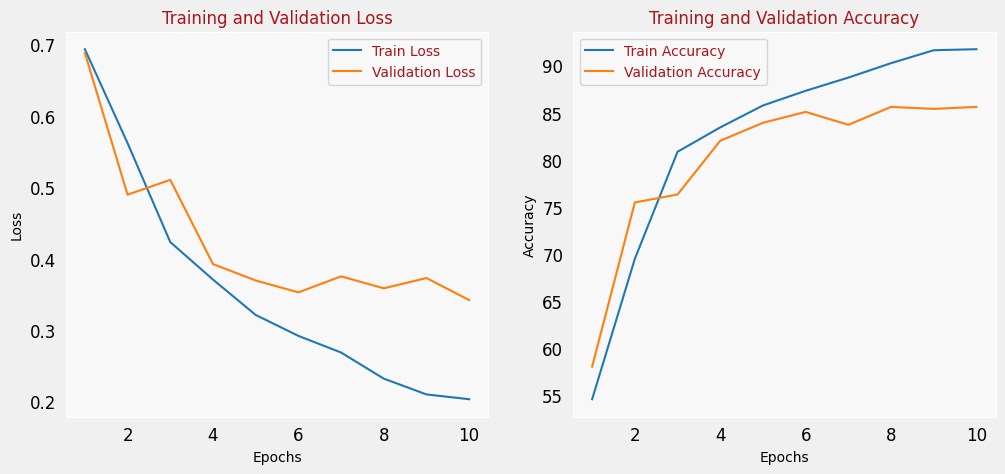

In [ ]:
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()  # Loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)

# for plotting
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

num_epochs = 10  # Number of training epochs

# Ensure the model is on the GPU
model = model.to(device)

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
      # Move inputs and labels to the same device as the model
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the parameter gradients

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(100 * correct_train / total_train)

    # Validation
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():  # Disable gradient computation
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move to GPU
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Calculate validation accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(100 * correct_val / total_val)

    print(f"Epoch {epoch + 1}/{num_epochs}, "
          f"Train Loss: {train_losses[-1]:.4f}, "
          f"Train Accuracy: {train_accuracies[-1]:.2f}%, "
          f"Val Loss: {val_losses[-1]:.4f}, "
          f"Val Accuracy: {val_accuracies[-1]:.2f}%")

# Plotting the training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


For our simple CNN, we obtain some remarkable results.



*  Over 10 epochs, the model exhibits a consistent improvement in training Performance, with a steady decrease in training loss and increase in training accuracy. However, the validation loss initially decreases but then fluctuates, indicating potential overfitting. Validation accuracy increases to a point and then plateaus, which suggests that while the model learns to classify the training data, its performance on unseen validation data could be improved.

For our second model, we will try a more complex architecture, specifically designed to improve the information we obtained from the previous model. Specifically, we will create a deeper network with more convolutional layers. This model aims to capture more complex features by adding depth.

**Design Choices:**
* **Additional Convolutional Layers:** Deeper layers can learn more complex and abstract representations of the data.
* **Batch Normalization:** Helps in faster convergence and stabilizes training.
* **Dropout:** Added to some of the fully connected layers to regularize and prevent overfitting.

In [ ]:
class DeeperCNN(nn.Module):
    def __init__(self):
        super(DeeperCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256 * 16 * 16, 1024)
        self.fc2 = nn.Linear(1024, 2)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.batch_norm2 = nn.BatchNorm2d(128)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(self.batch_norm1(F.relu(self.conv2(x))))
        x = self.pool(self.batch_norm2(F.relu(self.conv3(x))))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 256 * 16 * 16)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

Epoch 1/10, Train Loss: 1.0515, Train Accuracy: 69.36%, Val Loss: 0.5347, Val Accuracy: 74.02%
Epoch 2/10, Train Loss: 0.5716, Train Accuracy: 75.91%, Val Loss: 0.4236, Val Accuracy: 82.26%
Epoch 3/10, Train Loss: 0.4692, Train Accuracy: 80.43%, Val Loss: 0.6491, Val Accuracy: 73.92%
Epoch 4/10, Train Loss: 0.4886, Train Accuracy: 79.87%, Val Loss: 0.5580, Val Accuracy: 70.12%
Epoch 5/10, Train Loss: 0.4792, Train Accuracy: 79.56%, Val Loss: 0.3918, Val Accuracy: 84.37%
Epoch 6/10, Train Loss: 0.4461, Train Accuracy: 81.59%, Val Loss: 0.4283, Val Accuracy: 84.69%
Epoch 7/10, Train Loss: 0.3829, Train Accuracy: 83.76%, Val Loss: 0.3517, Val Accuracy: 86.91%
Epoch 8/10, Train Loss: 0.3686, Train Accuracy: 85.42%, Val Loss: 0.3738, Val Accuracy: 84.27%
Epoch 9/10, Train Loss: 0.3249, Train Accuracy: 86.37%, Val Loss: 0.3136, Val Accuracy: 87.01%
Epoch 10/10, Train Loss: 0.3195, Train Accuracy: 86.48%, Val Loss: 0.3381, Val Accuracy: 86.80%


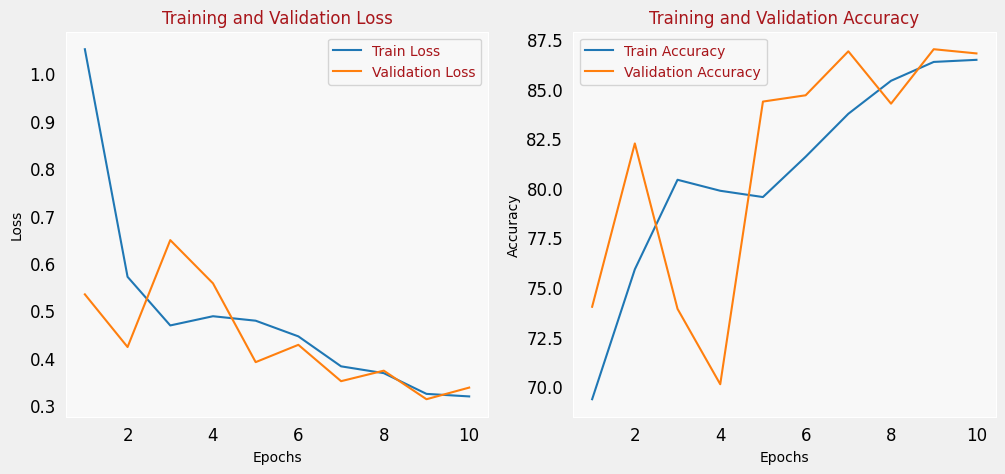

In [ ]:
model = DeeperCNN()
criterion = nn.CrossEntropyLoss()  # Loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)

# for plotting
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

num_epochs = 10  # Number of training epochs

# Ensure the model is on the GPU
model = model.to(device)

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
      # Move inputs and labels to the same device as the model
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the parameter gradients

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(100 * correct_train / total_train)

    # Validation
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():  # Disable gradient computation
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move to GPU
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Calculate validation accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(100 * correct_val / total_val)

    print(f"Epoch {epoch + 1}/{num_epochs}, "
          f"Train Loss: {train_losses[-1]:.4f}, "
          f"Train Accuracy: {train_accuracies[-1]:.2f}%, "
          f"Val Loss: {val_losses[-1]:.4f}, "
          f"Val Accuracy: {val_accuracies[-1]:.2f}%")

# Plotting the training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


The results from training the deeper neural network model show an interesting pattern in both the loss and accuracy over the epochs:


The training loss decreases more gradually compared to the simpler

*   The **training loss** decreases more gradually compared to the simpler model, but it starts higher in the initial epoch. This might be due to the increased complexity and the model requiring more time to start generalizing from the data.

*   The **validation loss** shows less fluctuation compared to the simpler model and decreases overall, indicating that the model is generalizing better and potentially benefiting from the added complexity and regularization techniques.

* The **training accuracy** starts higher and increases at a slower rate, which aligns with the behavior observed in the training loss. It doesn't reach as high as the simpler model, suggesting the deeper model is not overfitting the training data.

* The **validation accuracy** is more stable and consistently increases, surpassing the simpler model by the final epoch. This suggests the model is generalizing well and could potentially perform better on unseen data.

For the third architecture, we will design a network that introduces elements conducive to feature reusability and potentially more effective learning of complex patterns. We can incorporate a more modern architecture style that utilizes concepts like residual blocks, which are known for helping with training deeper networks. Such designs allow gradients to flow more easily through the network, which can be beneficial for both training efficiency and performance.

**Design Choices:**
* **Residual Blocks:** Implementing residual connections can help alleviate the vanishing gradient problem in deep networks by allowing direct paths for gradients during backpropagation.

* **Variable Dropout Rates:** Utilizing dropout with varying rates at different layers might help in understanding the optimal regularization needed at each layer.

* **Global Average Pooling:** Before the final fully connected layers, using global average pooling reduces the spatial dimensions to a single value per feature map. This helps to reduce the number of parameters significantly, focusing on the most salient features.

In [ ]:
class ResNetLikeCNN(nn.Module):
    def __init__(self):
        super(ResNetLikeCNN, self).__init__()
        # Define the initial convolutional layer
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Define the first residual block
        self.resblock1 = self._make_res_block(64, 64, stride=1)
        # Define the second residual block with increased number of filters
        self.resblock2 = self._make_res_block(64, 128, stride=2)

        # Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Define dropout layer with a variable rate
        self.dropout = nn.Dropout(0.3)  # A different dropout rate can be experimented with

        # Define the fully connected layer
        self.fc = nn.Linear(128, 2)

    def _make_res_block(self, in_channels, out_channels, stride):
        # Make a residual block with two convolutional layers
        layers = []
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False))
        layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False))
        layers.append(nn.BatchNorm2d(out_channels))

        # Shortcut connection
        shortcut = []
        if stride != 1 or in_channels != out_channels:
            shortcut.append(nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False))
            shortcut.append(nn.BatchNorm2d(out_channels))
        return nn.Sequential(*layers), nn.Sequential(*shortcut)

    def forward(self, x):
        # Initial convolution and pooling
        x = self.maxpool(self.relu(self.bn1(self.conv1(x))))

        # Pass through the first residual block
        identity = x
        out, shortcut = self.resblock1
        x = out(x) + shortcut(identity)
        x = self.relu(x)

        # Pass through the second residual block
        identity = x
        out, shortcut = self.resblock2
        x = out(x) + shortcut(identity)
        x = self.relu(x)

        # Global average pooling and classifier
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout(x)
        x = self.fc(x)

        return x


We start with a larger kernel size for the first convolutional layer to cover a wider receptive field initially.
- The `_make_res_block` method constructs a basic residual block with a shortcut connection. If the number of input and output channels is different or if we apply a stride, we add a shortcut convolution to match dimensions.

- Global average pooling reduces each feature map to a single number, minimizing overfitting and reducing the number of parameters.
Dropout with a variable rate is placed before the final fully connected layer. You can experiment with this rate to find an optimal value.

/usr/local/lib/python3.10/dist-packages/torch/utils/_device.py:78: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return func(*args, **kwargs)


Epoch 1/10, Train Loss: 0.6163, Train Accuracy: 66.27%, Val Loss: 0.5731, Val Accuracy: 71.28%
Epoch 2/10, Train Loss: 0.5877, Train Accuracy: 69.52%, Val Loss: 0.5854, Val Accuracy: 70.43%
Epoch 3/10, Train Loss: 0.5779, Train Accuracy: 70.18%, Val Loss: 0.5499, Val Accuracy: 72.02%
Epoch 4/10, Train Loss: 0.5753, Train Accuracy: 71.24%, Val Loss: 0.5626, Val Accuracy: 71.81%
Epoch 5/10, Train Loss: 0.5641, Train Accuracy: 71.08%, Val Loss: 0.5435, Val Accuracy: 71.70%
Epoch 6/10, Train Loss: 0.5580, Train Accuracy: 72.61%, Val Loss: 0.5429, Val Accuracy: 72.44%
Epoch 7/10, Train Loss: 0.5572, Train Accuracy: 72.45%, Val Loss: 0.5680, Val Accuracy: 70.64%
Epoch 8/10, Train Loss: 0.5442, Train Accuracy: 73.09%, Val Loss: 0.5381, Val Accuracy: 72.86%
Epoch 9/10, Train Loss: 0.5441, Train Accuracy: 72.93%, Val Loss: 0.5275, Val Accuracy: 73.92%
Epoch 10/10, Train Loss: 0.5404, Train Accuracy: 72.64%, Val Loss: 0.5366, Val Accuracy: 73.60%


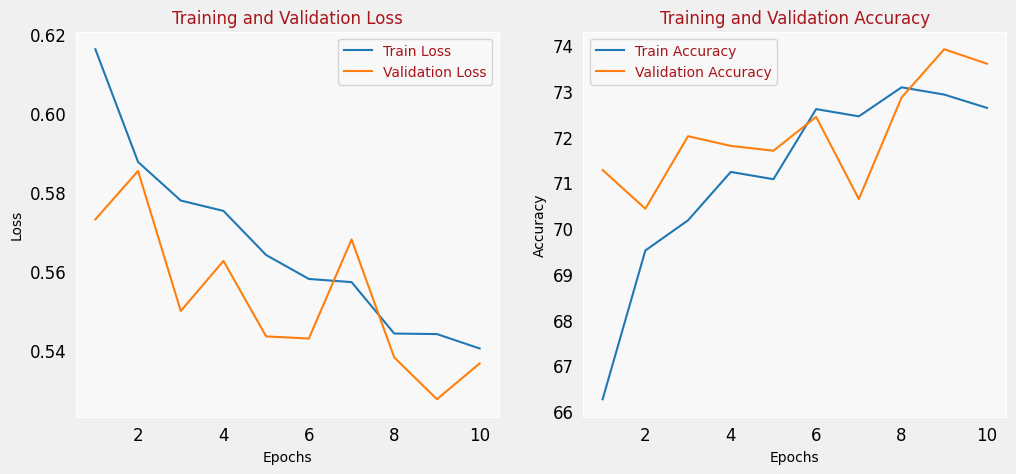

In [ ]:
model = ResNetLikeCNN()
criterion = nn.CrossEntropyLoss()  # Loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)

# for plotting
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

num_epochs = 10  # Number of training epochs

# Ensure the model is on the GPU
model = model.to(device)

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
      # Move inputs and labels to the same device as the model
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the parameter gradients

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(100 * correct_train / total_train)

    # Validation
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():  # Disable gradient computation
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move to GPU
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Calculate validation accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(100 * correct_val / total_val)

    print(f"Epoch {epoch + 1}/{num_epochs}, "
          f"Train Loss: {train_losses[-1]:.4f}, "
          f"Train Accuracy: {train_accuracies[-1]:.2f}%, "
          f"Val Loss: {val_losses[-1]:.4f}, "
          f"Val Accuracy: {val_accuracies[-1]:.2f}%")

# Plotting the training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


* The **training loss** of the third model displays a gentle reduction across epochs, punctuated by noticeable volatility. This pattern reflects the model's learning but hints at potential challenges in the training stability.
* **Validation loss** experiences swings and a less predictable trajectory compared to the second model, suggesting that while the model is improving, its generalization to the validation set is less stable and reliable.
* With regard to accuracy, the third model's **training accuracy** climbs modestly without reaching the heights of the second model, implying a slower and perhaps less optimized learning process.
* The **validation accuracy** also ascends incrementally, yet it fails to achieve the robustness or the peak performance of the second model. This could indicate that the third model is less adept at deciphering and generalizing the underlying patterns in the validation data.

### Comparison

- The second model outperforms the third in both training and validation accuracy, suggesting that its architecture and regularization strategies might be more effective for this task.

- The third model does show learning capability, but the fluctuations in its loss and accuracy metrics suggest that it may not be as stable as the second model. It's possible that this architecture could benefit from further tuning or additional training epochs to achieve better performance.

- The second model *(DeeperCNN)* is the stronger candidate based on the final validation accuracy and more consistent loss reduction.
For the third model *(ResNetLikeCNN*), additional epochs, hyperparameter tuning (such as learning rate adjustments or learning rate annealing), or even a simplification of the architecture could potentially improve results.



We can do a simple grid search on our model:

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

    return train_losses, train_accuracies, val_losses, val_accuracies

# Hyperparameters to test
learning_rates = [0.001, 0.0001]
batch_sizes = [64, 128]

# Use the best model to keep track of the best performing hyperparameters
best_accuracy = 0
best_settings = {}

# Grid search over learning rates and batch sizes
for lr in learning_rates:
    for batch_size in batch_sizes:
        print(f"Training with lr={lr}, batch_size={batch_size}")

        # Data loaders for training, validation, and testing
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, sampler=custom_sampler)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        model = DeeperCNN().to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        # Train and evaluate the model with current set of hyperparameters
        _, train_acc, _, val_acc = train_model(model, train_loader, val_loader, criterion, optimizer, 10, device)

        # Check if the current setting has the best validation accuracy
        if max(val_acc) > best_accuracy:
            best_accuracy = max(val_acc)
            best_settings = {'lr': lr, 'batch_size': batch_size}

# Print best configuration
print(f"Best settings: Learning Rate = {best_settings['lr']}, Batch Size = {best_settings['batch_size']}, with Validation Accuracy = {best_accuracy:.2f}%")

Training with lr=0.001, batch_size=64
Epoch 1/10, Train Loss: 3.8996, Train Acc: 65.72%, Val Loss: 0.5309, Val Acc: 74.13%
Epoch 2/10, Train Loss: 0.4384, Train Acc: 80.67%, Val Loss: 0.4310, Val Acc: 82.26%
Epoch 3/10, Train Loss: 0.3755, Train Acc: 83.52%, Val Loss: 0.3694, Val Acc: 84.58%
Epoch 4/10, Train Loss: 0.3468, Train Acc: 85.05%, Val Loss: 0.3901, Val Acc: 81.73%
Epoch 5/10, Train Loss: 0.3089, Train Acc: 86.98%, Val Loss: 0.3947, Val Acc: 82.47%
Epoch 6/10, Train Loss: 0.2906, Train Acc: 87.53%, Val Loss: 0.2998, Val Acc: 87.96%
Epoch 7/10, Train Loss: 0.2412, Train Acc: 90.52%, Val Loss: 0.4601, Val Acc: 84.90%
Epoch 8/10, Train Loss: 0.2373, Train Acc: 90.10%, Val Loss: 0.2901, Val Acc: 88.17%
Epoch 9/10, Train Loss: 0.2444, Train Acc: 89.49%, Val Loss: 0.2845, Val Acc: 89.02%
Epoch 10/10, Train Loss: 0.2060, Train Acc: 91.76%, Val Loss: 0.2831, Val Acc: 87.22%
Training with lr=0.001, batch_size=128
Epoch 1/10, Train Loss: 5.6785, Train Acc: 60.62%, Val Loss: 12.0767, Va

The provided code performs hyperparameter tuning using 5-fold cross-validation on a deep convolutional neural network (CNN) designed for binary image classification. The main objective is to find the optimal learning rate and batch size that yield the highest validation accuracy, ensuring robust generalization across different subsets of the dataset.

### Detailed Breakdown
- Train Model Function:
This function trains the given model using specified training and validation data loaders. It handles the training process over a defined number of epochs, performing forward and backward passes, and updates model weights using gradient descent. It tracks and returns the highest validation accuracy observed during training.

- K-Fold Cross-Validation:
Implements `K-fold` cross-validation using the KFold class from `sklearn.model_selection`. This function divides the dataset into n_splits (5 in this case) folds, ensuring each fold is used once as a validation set while the others are used for training.
It iterates over each fold, sets up data loaders for the training and validation subsets, initializes the model and associated optimization and loss calculation tools, and then calls train_model to train the model on the current fold.
Validation accuracies are collected across all folds and averaged to assess the performance of the model configuration (specific learning rate and batch size).

- Grid Search:
The script tests combinations of learning rates and batch sizes specified in learning_rates and batch_sizes. For each combination, it invokes `k_fold_cross_validation` to evaluate the model's performance over the dataset using 5-fold cross-validation.
It records and updates the best hyperparameter configuration based on the highest average validation accuracy across folds.

The best learning rate, batch size, and corresponding validation accuracy are printed out as the result of the grid search, indicating the optimal settings for training the model on this particular task.

A quick test for validation accuracy:

In [ ]:
from sklearn.model_selection import KFold

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    best_val_accuracy = 0  # Keep track of the best validation accuracy

    for epoch in range(num_epochs):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validation phase
        model.eval()
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_accuracy = 100 * correct_val / total_val
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy  # Update the best known validation accuracy

    return best_val_accuracy  # Return the best validation accuracy found

def k_fold_cross_validation(model_class, dataset, n_splits, lr, batch_size, num_epochs, device):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracies = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
        print(f"Fold {fold+1}/{n_splits}")
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
        val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)

        train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_subsampler)
        val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_subsampler)

        model = model_class().to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        val_accuracy = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)
        accuracies.append(val_accuracy)

    # Average accuracy across all folds
    average_accuracy = np.mean(accuracies)
    return average_accuracy


# Hyperparameters to test
learning_rates = [0.001, 0.0001]
batch_sizes = [64, 128]


# Grid search with cross-validation
best_accuracy = 0
best_settings = {}

for lr in learning_rates:
    for batch_size in batch_sizes:
        print(f"Testing with lr={lr}, batch_size={batch_size}")
        accuracy = k_fold_cross_validation(DeeperCNN, train_dataset, 5, lr, batch_size, 10, device)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_settings = {'lr': lr, 'batch_size': batch_size}

print(f"Best settings: Learning Rate = {best_settings['lr']}, Batch Size = {best_settings['batch_size']}, Validation Accuracy = {best_accuracy:.2f}%")


Testing with lr=0.001, batch_size=64
Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
Testing with lr=0.001, batch_size=128
Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
Testing with lr=0.0001, batch_size=64
Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5


**Result of code above (it runs very slow)**

*Best settings:*
- Learning Rate = 0.0001,
- Batch Size = 64,
- Validation Accuracy = 88.77%

Note; this is a manual grid search for demonstration purposes. In a real world scenario, tools like `RayTune` could be used. The grid is also small to account for computational needs and costs.

This is for zero-one loss error rate:

In [ ]:
# zero one loss
from sklearn.model_selection import KFold

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    best_val_error = 100  # Keep track of the lowest validation error rate

    for epoch in range(num_epochs):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validation phase
        model.eval()
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_error_rate = 100 * (1 - correct_val / total_val)
        if val_error_rate < best_val_error:
            best_val_error = val_error_rate  # Update the lowest known validation error rate

    return best_val_error  # Return the lowest validation error rate found

def k_fold_cross_validation(model_class, dataset, n_splits, lr, batch_size, num_epochs, device):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    error_rates = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
        print(f"Fold {fold+1}/{n_splits}")
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
        val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)

        train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_subsampler)
        val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_subsampler)

        model = model_class().to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        val_error_rate = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)
        error_rates.append(val_error_rate)

    # Average error rate across all folds
    average_error_rate = np.mean(error_rates)
    return average_error_rate


# Hyperparameters to test
learning_rates = [0.001, 0.0001]
batch_sizes = [64, 128]

# Grid search with cross-validation
best_error_rate = 100  # Initialize with 100% error rate
best_settings = {}

for lr in learning_rates:
    for batch_size in batch_sizes:
        print(f"Testing with lr={lr}, batch_size={batch_size}")
        error_rate = k_fold_cross_validation(DeeperCNN, train_dataset, 5, lr, batch_size, 10, device)

        if error_rate < best_error_rate:
            best_error_rate = error_rate
            best_settings = {'lr': lr, 'batch_size': batch_size}

print(f"Best settings: Learning Rate = {best_settings['lr']}, Batch Size = {best_settings['batch_size']}, with Zero-One Loss = {best_error_rate:.2f}%")


Testing with lr=0.001, batch_size=64
Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
Testing with lr=0.001, batch_size=128
Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
Testing with lr=0.0001, batch_size=64
Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5



## Model Evaluation and Discussion

The DeeperCNN architecture incorporates a series of convolutional layers, batch normalization, pooling layers, and dropout for regularization. The results from the 5-fold cross-validation indicate that the best performing configuration has a learning rate of $0.001$ and a batch size of $64$, achieving a cross-validated zero-one loss of $11.38$%.



- The architecture includes four convolutional layers, increasing in filter size from $32$ to $56$. This design choice allows the model to progressively learn more complex and abstract features from the input images.

- Batch normalization layers are included after the second and third convolutional layers, helping to stabilize and accelerate training. Batch normalization can also reduce the internal covariate shift, thereby improving the network's ability to generalize.

- Max pooling is used after each set of convolutional layers, reducing the spatial dimensions and retaining the most important features. This helps the model focus on dominant features, contributing to both efficiency and effectiveness.

- The dropout layer after the first fully connected layer helps prevent overfitting by randomly zeroing out a portion of the neurons. This forces the network to not rely too heavily on any one feature, thereby enhancing generalization.

**Influence of Hyperparameters on Cross-Validated Risk Estimate**

The results show that a learning rate of $0.001$ yielded the lowest cross-validated zero-one loss.
Learning rate controls the step size for updating weights. A lower learning rate ($0.0001$) resulted in a higher error rate, suggesting slower convergence and potentially not reaching an optimal solution within the allocated epochs.
On the other hand, a higher learning rate could lead to overshooting minima, leading to higher loss or instability.


A batch size of $64$ resulted in the lowest error rate.
Smaller batch sizes typically offer better generalization, as seen in the results, because they introduce more noise into the gradient estimation process, which can act as a form of regularization.
Larger batch sizes ($128$) resulted in slightly higher error rates, which could be due to the network converging to sharper minima that generalize less effectively.

**Final Cross-Validated Risk Estimate**

The final cross-validated risk estimate, as indicated by the zero-one loss, is $11.38%$ for the best-performing configuration.
This risk estimate reflects the proportion of incorrect classifications, making it a direct measure of the network's classification error rate.